In [1]:
# Disable warnings in Anaconda
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
from matplotlib import rcParams

rcParams["figure.figsize"] = 11, 8

In [3]:
def fill_nan(table):
    for col in table.columns:
        table[col] = table[col].fillna(table[col].median())
    return table

In [4]:
# for Jupyter-book, we copy data from GitHub, locally, to save Internet traffic,
# you can specify the data/ folder from the root of your cloned
# https://github.com/Yorko/mlcourse.ai repo, to save Internet traffic
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/data/"

In [5]:
data = pd.read_csv(DATA_PATH + "credit_scoring_sample.csv", sep=";")
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [6]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Distribution of the target:


SeriousDlqin2yrs
0    0.777511
1    0.222489
Name: count, dtype: float64

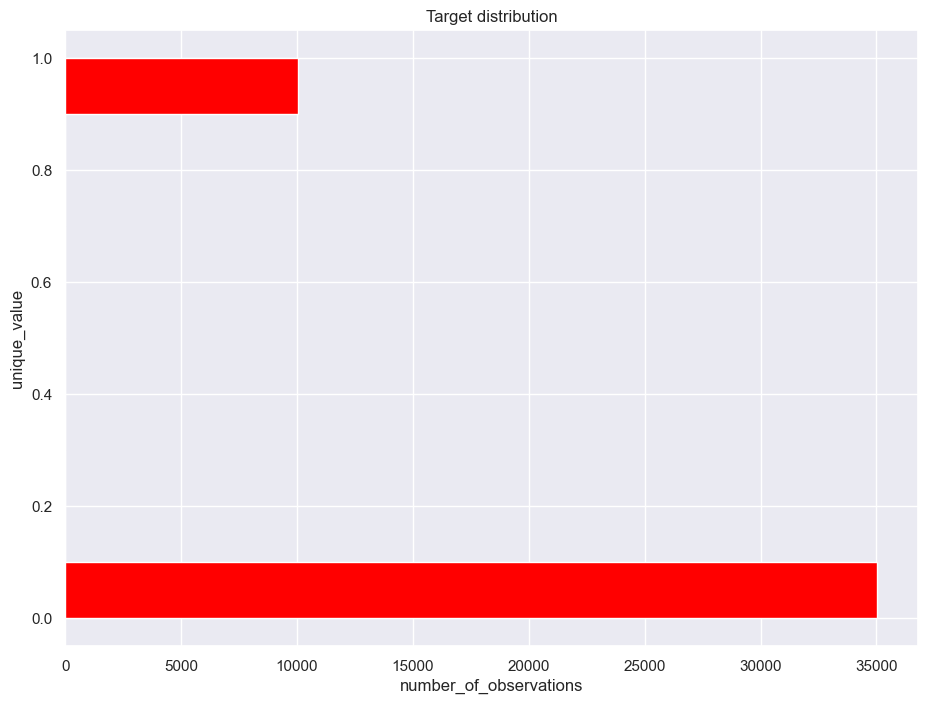

In [7]:
ax = data["SeriousDlqin2yrs"].hist(orientation="horizontal", color="red")
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print("Distribution of the target:")
data["SeriousDlqin2yrs"].value_counts() / data.shape[0]

In [8]:
independent_columns_names = [x for x in data if x != "SeriousDlqin2yrs"]
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

In [9]:
table = fill_nan(data)

In [10]:
X = table[independent_columns_names]
y = table["SeriousDlqin2yrs"]

In [11]:
#2
def get_bootstrap_samples(data, n_samples):
    """Generate bootstrap samples using the bootstrap method."""
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples


def stat_intervals(stat, alpha):
    """Produce an interval estimate."""
    boundaries = np.percentile(stat, [100 * alpha / 2.0, 100 * (1 - alpha / 2.0)])
    return boundaries

In [12]:
churn = data[data["SeriousDlqin2yrs"] == 1]["age"].values
np.random.seed(0)
churn_score = [
    np.mean(sample) for sample in get_bootstrap_samples(churn,1000)
]
print(
    "mean interval", stat_intervals(churn_score, 0.1)
)

mean interval [45.71379414 46.12700479]


In [13]:
#3
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [14]:
lr = LogisticRegression(random_state=5, class_weight="balanced")

In [15]:
parameters = {"C": (0.0001, 0.001, 0.01, 0.1, 1, 10)}

In [16]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

In [17]:
grid_search = GridSearchCV(lr,parameters,n_jobs=-1,scoring="roc_auc",cv=skf)
grid_search.fit(X,y)
grid_search.best_estimator_

LogisticRegression(C=10, class_weight='balanced', random_state=5)

In [18]:
grid_search.cv_results_["std_test_score"][1]

0.00757143893089803

In [19]:
grid_search.best_score_

0.79611062005143

In [20]:
#4
from sklearn.preprocessing import StandardScaler

lr = LogisticRegression(C=10, random_state=5, class_weight="balanced")
scal = StandardScaler()
lr.fit(scal.fit_transform(X), y)

pd.DataFrame(
    {"feat": independent_columns_names, "coef": lr.coef_.flatten().tolist()}
)

,feat,coef
0,age,-0.436555
1,NumberOfTime30-59DaysPastDueNotWorse,3.276867
2,DebtRatio,-0.041773
3,NumberOfTimes90DaysLate,3.067259
4,NumberOfTime60-89DaysPastDueNotWorse,0.076824
5,MonthlyIncome,-0.203801
6,NumberOfDependents,0.085393


In [23]:
#5
print((np.exp(lr.coef_[0]) / np.sum(np.exp(lr.coef_[0])))[2])

0.018245554281686786


In [39]:
#6
lr = LogisticRegression(C=10, random_state=5, class_weight="balanced")
lr.fit(X, y)

pd.DataFrame(
    {"feat": independent_columns_names, "coef": lr.coef_.flatten().tolist()}
)


,feat,coef
0,age,-0.014673
1,NumberOfTime30-59DaysPastDueNotWorse,0.491247
2,DebtRatio,-0.000007
3,NumberOfTimes90DaysLate,0.451514
4,NumberOfTime60-89DaysPastDueNotWorse,0.258973
5,MonthlyIncome,-0.000012
6,NumberOfDependents,0.198535


In [27]:
np.exp(lr.coef_[0][0] * 20)

0.745674899835497

In [28]:
#7
from sklearn.ensemble import RandomForestClassifier

In [29]:
rf = RandomForestClassifier(
    n_estimators=100, n_jobs=-1, random_state=42, class_weight="balanced"
)

In [30]:
parameters = {
    "max_features": [1, 2, 4],
    "min_samples_leaf": [3, 5, 7, 9],
    "max_depth": [5, 10, 15],
}

In [32]:
rf_grid_search = GridSearchCV(rf,parameters,n_jobs=-1,scoring="roc_auc",cv=skf)
rf_grid_search.fit(X,y)
print(rf_grid_search.best_score_- grid_search.best_score_)

0.03966792505182326


In [37]:
pd.DataFrame(
    {"feat": independent_columns_names, "coef": rf_grid_search.best_estimator_.feature_importances_}
)

,feat,coef
0,age,0.115860
1,NumberOfTime30-59DaysPastDueNotWorse,0.300290
2,DebtRatio,0.076082
3,NumberOfTimes90DaysLate,0.278749
4,NumberOfTime60-89DaysPastDueNotWorse,0.156534
5,MonthlyIncome,0.057994
6,NumberOfDependents,0.014491


In [58]:
#8
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

parameters = {
    "max_features": [2, 3, 4],
    "max_samples": [0.5, 0.7, 0.9],
    "estimator__C": [0.0001, 0.001, 0.01, 1, 10, 100],
}

In [59]:
bg = BaggingClassifier(estimator=LogisticRegression(class_weight="balanced"), n_estimators=100, n_jobs=-1, random_state=42)
bg_grid_search = RandomizedSearchCV(bg, parameters, n_jobs=-1, scoring="roc_auc", cv=skf, n_iter=20, random_state=1)
bg_grid_search.fit(X, y)
bg_grid_search.best_score_
# bg = BaggingClassifier(estimator=LogisticRegression(class_weight="balanced"), n_estimators=100, n_jobs=-1, random_state=42)
# bg_grid_search = RandomizedSearchCV(bg, {'estimator__C': [0.001, 0.1, 1, 10, 100]}, n_jobs=-1, scoring="roc_auc", cv=skf, n_iter=20, random_state=1)
# bg_grid_search.fit(X, y)
# bg_grid_search.best_score_

0.8058535129456807